In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops

def swish(features, name=None):
  """Computes Self-Gated activation`.
  Source: [SWISH: A SELF-GATED ACTIVATION FUNCTION](https://arxiv.org/pdf/1710.05941.pdf)
  Args:
    features: A `Tensor` with type `float`, `double`, `int32`, `int64`, `uint8`,
      `int16`, or `int8`.
    name: A name for the operation (optional).
  Returns:
    A `Tensor` with the same type as `features`.
  """
  with ops.name_scope(name, "swish", [features]) as name:
    features = ops.convert_to_tensor(features, name="features")
    return tf.multiply(features , tf.nn.sigmoid(features), name=name)

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import tensorpack as tp

from tensorpack import dataset
from tensorpack.dataflow import imgaug, AugmentImageComponent, BatchData, PrefetchData
import tensorpack.tfutils.symbolic_functions as symbf

import tensorflow.contrib.slim as slim
from tensorflow.python.training import optimizer

class ModelMNIST10x10_simple(object):
    def __init__(self, learning_rate=0.001, batch_size=128):
        self.batch_size = batch_size
        self.inputs = [
            tf.placeholder(tf.float32, shape=(None, 10, 10, 1)),
            tf.placeholder(tf.int32, shape=(None,)),
            tf.placeholder(tf.float32, shape=(None, 10))
        ]
        
        self.probability, self.cost, self.accuracy = self._build_graph(self.inputs)
        self.op = self._get_optimize_operator(self.cost, learning_rate)
        self.dataflow = {
            'train':self._get_data('train'),
            'valid':self._get_data('test'),
        }
        
    def _build_graph(self, inputs):
        image, label, vector = inputs
        
        with slim.arg_scope([slim.layers.conv2d], weights_regularizer=slim.l2_regularizer(1e-4), activation_fn=swish), \
             slim.arg_scope([slim.layers.fully_connected], weights_regularizer=slim.l2_regularizer(1e-5), activation_fn=swish):
            l = slim.layers.conv2d(image, 8, [3, 3], padding='SAME', scope='conv0' ) # 10x10
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool0') # 5x5
            l = slim.layers.conv2d(l, 16, [3, 3], scope='conv1') # 3x3
            l = slim.layers.conv2d(l, 32, [3, 3], scope='conv2') # 1x1
            l = slim.layers.flatten(l, scope='flatten')
            l = slim.layers.fully_connected(l, 512, scope='fc0')
            logits = slim.layers.fully_connected(l, 10, activation_fn=None, scope='fc1')

        #cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=vector)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')

        prob = tf.nn.softmax(logits, name='prob')
        accuracy = symbf.accuracy(logits, label, topk=1)
        return prob, cost, accuracy
    
    def _get_optimize_operator(self, cost, learning_rate=0.1):
        var_list = (tf.trainable_variables() + tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))
        var_list += tf.get_collection(tf.GraphKeys._STREAMING_MODEL_PORTS)

        processors = [optimizer._get_processor(v) for v in var_list]
        var_refs = [p.target() for p in processors]
        
        # compute_gradients
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        grads_and_vars = list(zip(grads, var_list))
        
        self.grads = grads
        opt = tf.train.AdamOptimizer(learning_rate)
        return opt.apply_gradients(grads_and_vars)
    
    def _get_data(self, train_or_test):
        BATCH_SIZE = self.batch_size
        isTrain = train_or_test == 'train'
        ds = dataset.Mnist(train_or_test)
        if isTrain:
            augmentors = [
#                imgaug.RandomApplyAug(imgaug.RandomResize((0.8, 1.2), (0.8, 1.2)), 0.3),
#                imgaug.RandomApplyAug(imgaug.RotationAndCropValid(15), 0.5),
#                imgaug.RandomApplyAug(imgaug.SaltPepperNoise(white_prob=0.01, black_prob=0.01), 0.25),
                imgaug.Resize((10, 10)),
                imgaug.CenterPaste((12, 12)),
                imgaug.RandomCrop((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        else:
            augmentors = [
                imgaug.Resize((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        ds = AugmentImageComponent(ds, augmentors)
        ds = BatchData(ds, BATCH_SIZE, remainder=not isTrain)
        if isTrain:
            ds = PrefetchData(ds, 3, 2)
        return ds

In [3]:
model = ModelMNIST10x10_simple(batch_size=128)

[1023 13:38:01 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.


In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [5]:
import sklearn.preprocessing

history = []
for epoch in range(30):
    result = {}
    
    model.dataflow['train'].reset_state()
    step, costs, accuracies = 0, [], []
    for datapoint in model.dataflow['train'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        _, cost, accuracy, grads = sess.run([model.op, model.cost, model.accuracy, model.grads],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        grads = [np.sum(np.abs(g)) for g in grads]
        costs.append(cost)
        accuracies.append(accuracy)
        step += 1
        #print('[train] epoch:%04d step:%04d cost:%.3f accuracy:%0.3f'%(epoch, step, cost, accuracy))
    print('[%04d] [train] cost:%.3f accuracy:%0.3f'%(epoch+1, np.mean(costs), np.mean(accuracies)), end=' ')
    result['train'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies), 'grads_abs':grads}

    model.dataflow['valid'].reset_state()
    costs, accuracies = [], []
    for datapoint in model.dataflow['valid'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        cost, accuracy = sess.run([model.cost, model.accuracy],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        costs.append(cost)
        accuracies.append(accuracy)
        
    print('[valid] cost:%.3f accuracy:%0.3f'%(np.mean(costs), np.mean(accuracies)))
    result['valid'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies)}
    
    history.append( result )

[0001] [train] cost:0.188 accuracy:0.642 [valid] cost:0.091 accuracy:0.853
[0002] [train] cost:0.068 accuracy:0.892 [valid] cost:0.046 accuracy:0.925
[0003] [train] cost:0.045 accuracy:0.929 [valid] cost:0.035 accuracy:0.946
[0004] [train] cost:0.036 accuracy:0.944 [valid] cost:0.030 accuracy:0.953
[0005] [train] cost:0.031 accuracy:0.953 [valid] cost:0.025 accuracy:0.962
[0006] [train] cost:0.027 accuracy:0.957 [valid] cost:0.024 accuracy:0.963
[0007] [train] cost:0.024 accuracy:0.963 [valid] cost:0.022 accuracy:0.965
[0008] [train] cost:0.022 accuracy:0.966 [valid] cost:0.021 accuracy:0.968
[0009] [train] cost:0.021 accuracy:0.967 [valid] cost:0.020 accuracy:0.967
[0010] [train] cost:0.019 accuracy:0.971 [valid] cost:0.018 accuracy:0.972
[0011] [train] cost:0.018 accuracy:0.973 [valid] cost:0.018 accuracy:0.973
[0012] [train] cost:0.018 accuracy:0.973 [valid] cost:0.017 accuracy:0.973
[0013] [train] cost:0.017 accuracy:0.974 [valid] cost:0.017 accuracy:0.974
[0014] [train] cost:0.015

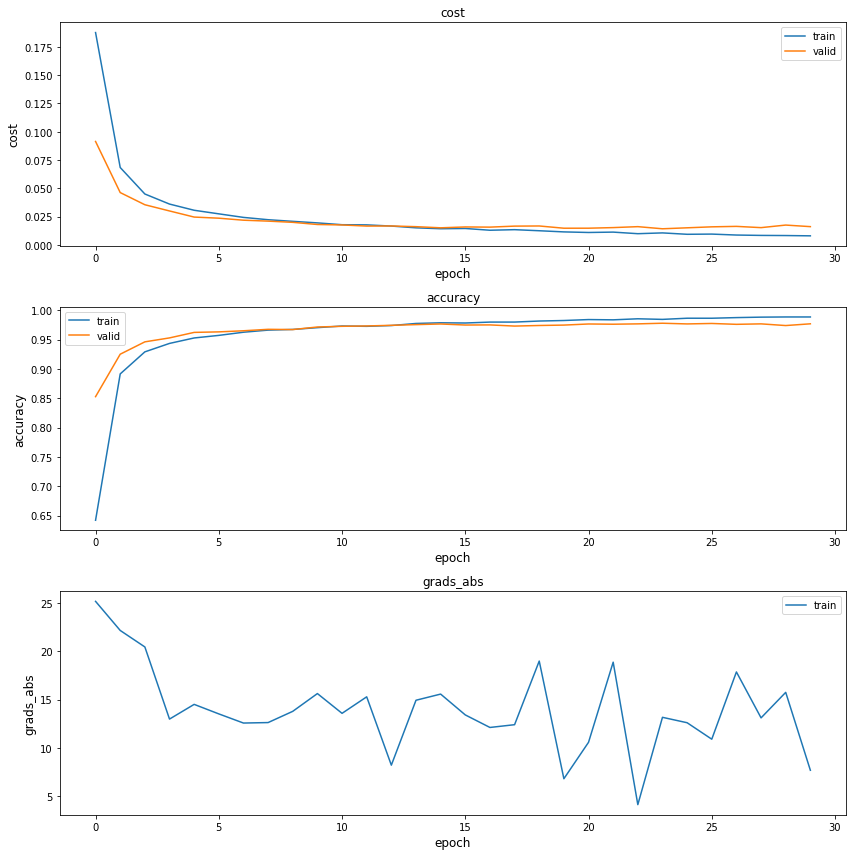

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 4*3))
for i, label in enumerate(['cost', 'accuracy', 'grads_abs']):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(label, fontsize=12)
    for j, mode in enumerate(['train', 'valid']):
        if not label in history[0][mode]:
            continue
        ax.plot(np.array([h[mode]['epoch'] for h in history]), np.array([np.sum(h[mode][label]) for h in history]), label=mode)
    ax.legend()
plt.tight_layout()